In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
from keras.utils import to_categorical
from collections import OrderedDict
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [2]:
from platform import python_version
print(python_version())

3.6.6


### Exp of classifing movie genres based on their events.


In [29]:
movies = pd.read_csv('../../data/metadata_events_table.tsv', sep = '\t')

In [30]:
movies.Genre_code.value_counts()

2    2421
4    1637
1    1229
3     669
0     494
Name: Genre_code, dtype: int64

In [33]:
df0 = movies[movies['Genre_code'] == 0].sample(500, replace = True)
df1 = movies[movies['Genre_code'] == 1].sample(500)
df2 = movies[movies['Genre_code'] == 2].sample(500)
df3 = movies[movies['Genre_code'] == 3].sample(500)
df4 = movies[movies['Genre_code'] == 4].sample(500)

In [34]:
movies = pd.concat([df0, df1, df2, df3, df4])

In [35]:
movies.head()

,Wikipedia_id,Freebase_id,Name,Release_date,Revenue,Runtime,Languages,Countries,Genres,Events,Genre_code
3432,14467499,/m/03d4h04,Ek Musafir Ek Hasina,1962,NaN,NaN,dict_values(['Hindi Language']),dict_values(['India']),Action,"['protagonist hurt-40.8.3-2', 'protagonist hur...",0
2266,1830431,/m/05_cq9,The Legend of Zorro,2005-10-24,142400065.0,129.0,dict_values(['English Language']),dict_values(['United States of America']),Action,"['protagonist chase-51.6', 'protagonist steal-...",0
4036,2853229,/m/086yvw,Thiruda Thiruda,1993,NaN,152.0,"dict_values(['Hindi Language', 'Tamil Language'])",dict_values(['India']),Action,"['protagonist interrogate-37.1.3', 'protagonis...",0
4815,3834822,/m/0b2g2k,Hombre,1967-03-21,12000000.0,111.0,dict_values(['English Language']),dict_values(['United States of America']),Action,"['protagonist stop-55.4-1', 'protagonist stop-...",0
560,75255,/m/0j_sn,The Naked Spur,1953,2250000.0,91.0,dict_values(['English Language']),dict_values(['United States of America']),Action,"['protagonist stalk-35.3', 'protagonist contig...",0


In [36]:
len(movies)

2500

### Encode as one-hot vectors

In [37]:
t = Tokenizer()

In [38]:
events = []
for e in movies.Events.tolist():
    events.append([item.split('-')[0] for item in eval(e)])

In [39]:
# Size of data
print(len(events))

2500


In [40]:
t.fit_on_texts(events)

In [41]:
t.word_index

{'protagonist amuse': 1,
 'protagonist get': 2,
 'protagonist escape': 3,
 'protagonist discover': 4,
 'protagonist meander': 5,
 'protagonist conjecture': 6,
 'protagonist transfer_mesg': 7,
 'protagonist own': 8,
 'protagonist say': 9,
 'protagonist become': 10,
 'protagonist correspond': 11,
 'protagonist force': 12,
 'protagonist other_cos': 13,
 'protagonist admit': 14,
 'protagonist obtain': 15,
 'protagonist give': 16,
 'protagonist meet': 17,
 'protagonist appear': 18,
 'protagonist contiguous_location': 19,
 'protagonist convert': 20,
 'protagonist involve': 21,
 'protagonist steal': 22,
 'protagonist future_having': 23,
 'protagonist begin': 24,
 'protagonist characterize': 25,
 'protagonist admire': 26,
 'protagonist run': 27,
 'protagonist reflexive_appearance': 28,
 'protagonist subjugate': 29,
 'protagonist send': 30,
 'protagonist seem': 31,
 'protagonist calibratable_cos': 32,
 'protagonist judgment': 33,
 'protagonist sight': 34,
 'protagonist remove': 35,
 'protagonis

In [42]:
embedding_input_dim = max(t.word_index.values())+1

In [43]:
embedding_input_dim

630

In [44]:
msk = np.random.rand(len(movies)) < 0.8
train = []
for e in movies[msk]['Events'].tolist():
    train.append([item.split('-')[0] for item in eval(e)])
test = []
for e in movies[~msk]['Events'].tolist():
    test.append([item.split('-')[0] for item in eval(e)])


In [46]:
x_train = t.texts_to_sequences(train)
x_train = pad_sequences(x_train, maxlen=50)


In [47]:
events_trans = t.texts_to_sequences(events)
events_trans = pad_sequences(events_trans, maxlen=50)


In [49]:
x_test = t.texts_to_sequences(test)
x_test = pad_sequences(x_test, maxlen=20)


In [50]:
y_train = to_categorical(movies[msk]['Genre_code'].tolist())
y_test = to_categorical(movies[~msk]['Genre_code'].tolist())

### Simple LSTM 

In [51]:
# create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length))
model.add( LSTM(20))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          20160     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 24,505
Trainable params: 24,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
2029/2029 [==============================] - 3s 1ms/step - loss: 1.6070 - acc: 0.2287
Epoch 2/3
2029/2029 [==============================] - 2s 895us/step - loss: 1.5718 - acc: 0.3401
Epoch 3/3
2029/2029 [==============================] - 2s 888us/step - loss: 1.4734 - acc: 0.3549


In [52]:
# Final evaluation of the model
scores = model.evaluate(x_test,
                        y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

471/471 [==============================] - 0s 333us/step
Accuracy: 34.61%


### Obtain embeddings

In [53]:
model.layers

In [54]:
# #Get indimediate layer output using tensorflow backend
# get_lstm_output = K.function([model.layers[0].input], [model.layers[1].output])
# output = get_lstm_output([x_train])

In [55]:
#Alternative way, same result
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('lstm_2').output)
# intermediate_output = intermediate_layer_model.predict(x_train[0][0:])

In [59]:
vecs = []
for i in range(len(events)):
    output = intermediate_layer_model.predict(events_trans[i])
#     print(output.shape)
#     print(output[0])
#     break
    vecs.append(output[-1])


### Cluster embeddings

In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans


In [61]:
embedded = TSNE(n_components=2).fit_transform(vecs)
embedded.shape

(2500, 2)

In [62]:
embedded[:,0].shape

(2500,)

In [63]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

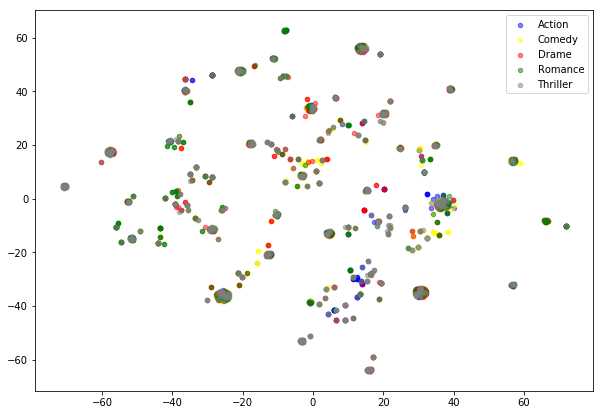

In [68]:
plt.figure(figsize = (10,7))
plt.scatter(embedded[0:500,0], embedded[0:500,1], s = 20,color='blue', label = 'Action', alpha = 0.5)
plt.scatter(embedded[500:1000,0], embedded[500:1000,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)
plt.scatter(embedded[1000:1500,0], embedded[1000:1500,1], s = 20,color='red', label = 'Drame', alpha = 0.5)
plt.scatter(embedded[1500:2000,0], embedded[1500:2000,1], s = 20,color='green', label = 'Romance', alpha = 0.5)
plt.scatter(embedded[2000:,0], embedded[2000:,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
plt.legend()